In [1]:
from lsdt_dynasim import*

from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import math
from scipy.interpolate import interp1d
  
#########################################################################
##### Beschreibung Programm #############################################
#########################################################################

""" 
Das Programm dient der Berechnung des Systemverhaltens von Schwingungsfähigen Systemen

Bemerkungen:
- Die numerische Berechnung erfolgt mittels Runge Kutta Verfahren (RK4)
- Die Genauigkeit der Ergebnisse hängen von der Zeitschrittweite und der Simulationsdauer ab
- Eine zu kein gewählte Schrittweite führt in der Regel zu einer Energiezufuhr ins System
- Je höher die Steifigkeit des Systems, desto kleiner muss die Simulationsschrittweite gewählt werden
"""

#########################################################################
##### Allgemeine Einstellungen ##########################################
#########################################################################

Bilder_speichern                     = True
CSV_speichern                        = True
CSV_speichern_Blender                = False

#########################################################################
##### Messung einlesen (optional) #######################################
#########################################################################

#########################################################################
##### Simulationsparameter ##############################################
#########################################################################

Input_t_start                        = 0
Input_t_ende                         = 1
Input_delta_t                        = 0.0001         # Zeitschrittweite

# Initial and end values
Input_gx                             = 0             # Gravitationsbeschleunigung x-Richtung, Standard: 0
Input_gy                             = 0             # Gravitationsbeschleunigung y-Richtung, Standard: 0
Input_gz                             = -9.81         # Gravitationsbeschleunigung z-Richtung, Standard: -9.81

# Numerische Einstellungen
dALEMBERT_max_fehler_rotx_pp         = 0.001
dALEMBERT_schrittweite_rotx_pp       = 0.0001

# Kinematische Größen
Input_Kinematik_Ri                   = 1              # Radius
Input_Kinematik_Ra                   = 1.5            # Radius
 
# Initial and end values
Input_E2_Masse_m                     = 30             # Masse
Input_E3_Masse_m                     = 11.95          # Masse
Input_E1_gelagerteRolle_Theta        = 0.5 * Input_E2_Masse_m * pow(Input_Kinematik_Ra,2)       # Massenträgheit


#########################################################################
##### Anfangsrandbedingungen der Elemente ###############################
#########################################################################


#########################################################################
##### Erstellung aller Elemente #########################################
#########################################################################
"""
Modell:
    E1:   Rolle dALEMBERT Primary
    E2:   Masse dALEMBERT Secondary
    E3:   Masse dALEMBERT Secondary
"""

E1                               = class_dALEMBERT_Primary_Rolle_rotx(Input_E1_gelagerteRolle_Theta, dALEMBERT_max_fehler_rotx_pp, dALEMBERT_schrittweite_rotx_pp, [K1])
E2                               = class_dALEMBERT_Secondary_Masse_z(Input_E2_Masse_m, Input_gz, [K2])
E3                               = class_dALEMBERT_Secondary_Masse_z(Input_E3_Masse_m, Input_gz, [K3])

Verbindung_dALEMBERT1            = class_Verbindung_dALEMBERT_Secondary_z_an_Primary_rotx(Input_Kinematik_Ra, -1, [K2, K1]) #-1: Positives Fy führt zu negativem Moment an der Rolle
Verbindung_dALEMBERT2            = class_Verbindung_dALEMBERT_Secondary_z_an_Primary_rotx(Input_Kinematik_Ri,  1, [K3, K1]) # 1: Positives Fy führt zu positivem Moment an der Rolle

#########################################################################
##### Start der Simulation ##############################################
#########################################################################

t = Input_t_start
while (t < Input_t_ende):    
    E1.set_Konvergenz(False)
    while (E1.return_Konvergenz() == False):
        # Erst einmal alle Knotenkräfte zu Null setzen, da diese an den Knoten aufsummiert werden
        Reset_Knotenkraefte()    

        #Berechnung der Kräfte an den Federn und Dämpfern
        #    für alle Elemente
        E1.Berechnung_Kraefte()    
        E2.Berechnung_Kraefte()        
        E3.Berechnung_Kraefte()       
        Verbindung_dALEMBERT1.Beidseitige_Uebertragung_Werte()
        Verbindung_dALEMBERT2.Beidseitige_Uebertragung_Werte()

        #Berechung der massebehafteten Elemente  
        #    nur für Elemente mit Masse
        E1.Einzelschritt_Anpassung_rotz_pp()                    
                    
    # Berechnung Energien    
    #    für alle Elemente
    E1.Berechnung_Energien(Input_delta_t)    
    E2.Berechnung_Energien(Input_delta_t)        
    E3.Berechnung_Energien(Input_delta_t)        
                   
    E1.Festsetzung_Ergebnisse(Input_delta_t)                                              
    
    # Datenlogger Knoten
    Datenlogger_Knoten_schreiben(t)
    
    #Datenlogger Elemente
    #    für alle Elemente
    datenlogger_E1.Werte_anhaengen(E1)    
    datenlogger_E2.Werte_anhaengen(E2)    
    datenlogger_E3.Werte_anhaengen(E3)    
    
    t = t + Input_delta_t

if (CSV_speichern == True):
    csv_schreiben('../output_csv/lsdt_dynasim_rolle_mit_zwei_gewichten.csv',datenlogger_K1)
    
if (CSV_speichern_Blender == True):
    csv_schreiben('../output_csv_blender/lsdt_dynasim_rolle_mit_zwei_gewichten_K1.csv',datenlogger_K1)

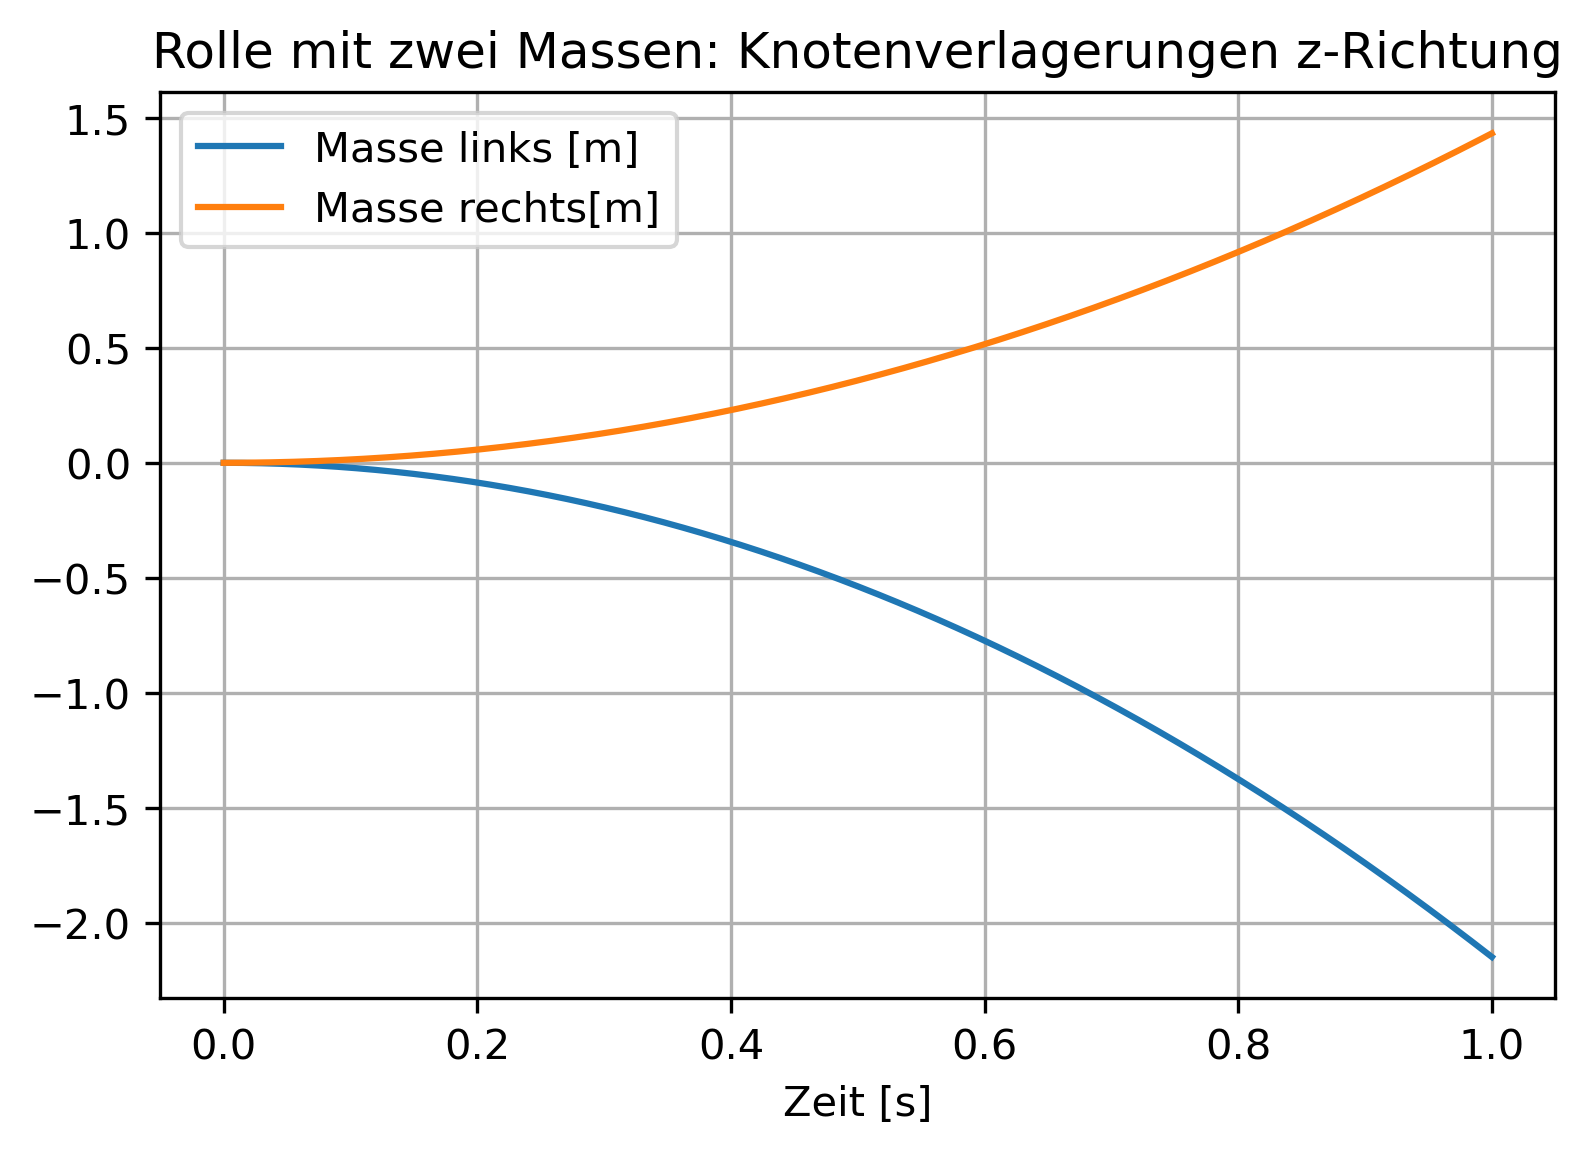

In [2]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Rolle mit zwei Massen: Knotenverlagerungen z-Richtung')
plt.plot(datenlogger_t,datenlogger_K2.z,label='Masse links [m]')
plt.plot(datenlogger_t,datenlogger_K3.z,label='Masse rechts[m]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_rolle_mit_zwei_gewichten1.png')

Phi_pp: 2.8641386925795054


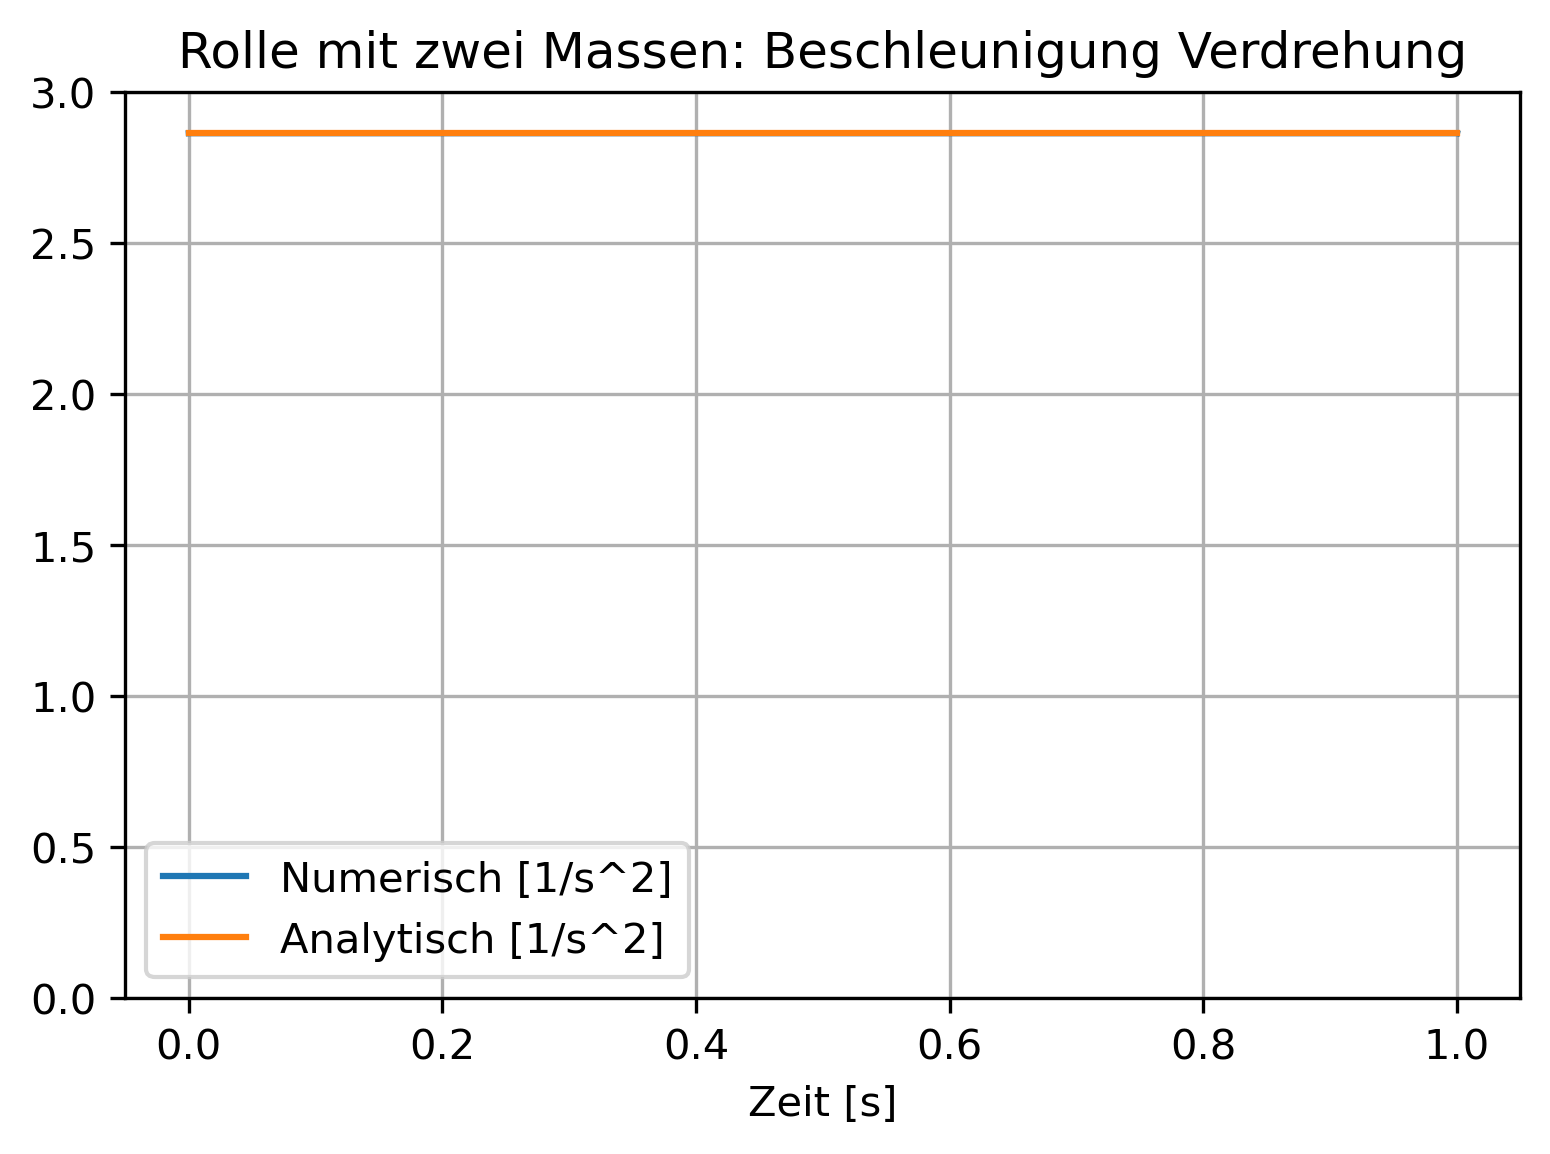

In [3]:
#Analytische Lösung:
phi_pp = abs(Input_gz) * (Input_E2_Masse_m * Input_Kinematik_Ra - Input_E3_Masse_m * Input_Kinematik_Ri) / (1.5 * Input_E2_Masse_m * pow(Input_Kinematik_Ra,2) + Input_E3_Masse_m * pow(Input_Kinematik_Ri,2))
print("Phi_pp: "+str(phi_pp))
zeit    = [0, Input_t_ende]
rotx_pp = [phi_pp, phi_pp]
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Rolle mit zwei Massen: Beschleunigung Verdrehung')
plt.plot(datenlogger_t,datenlogger_K1.rotx_pp,label='Numerisch [1/s^2]')
plt.plot(zeit,rotx_pp,label='Analytisch [1/s^2]')
plt.ylim(0,3)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_rolle_mit_zwei_gewichten2.png')

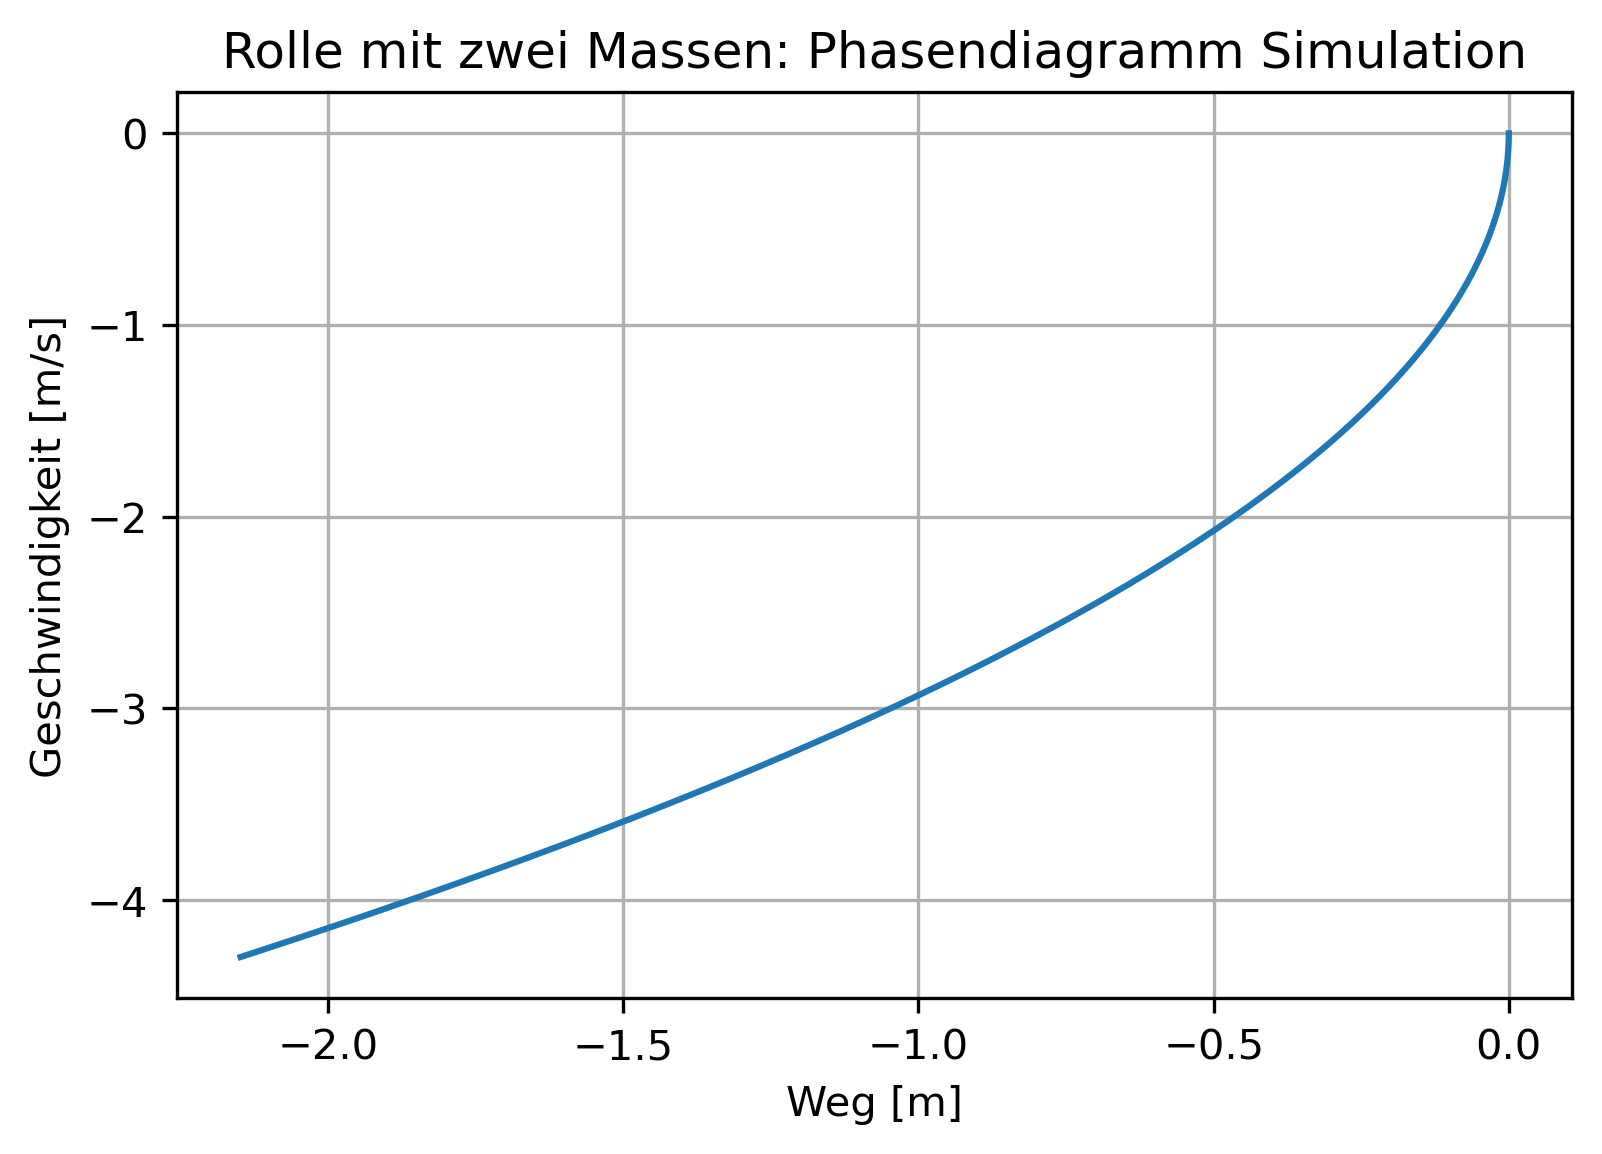

In [4]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Rolle mit zwei Massen: Phasendiagramm Simulation')
plt.plot(datenlogger_K2.z,datenlogger_K2.z_p,label='K2 [N]')
#plt.xlim(0,20)
plt.xlabel('Weg [m]')
plt.ylabel('Geschwindigkeit [m/s]')
plt.grid(True)
#plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_rolle_mit_zwei_gewichten3.png')

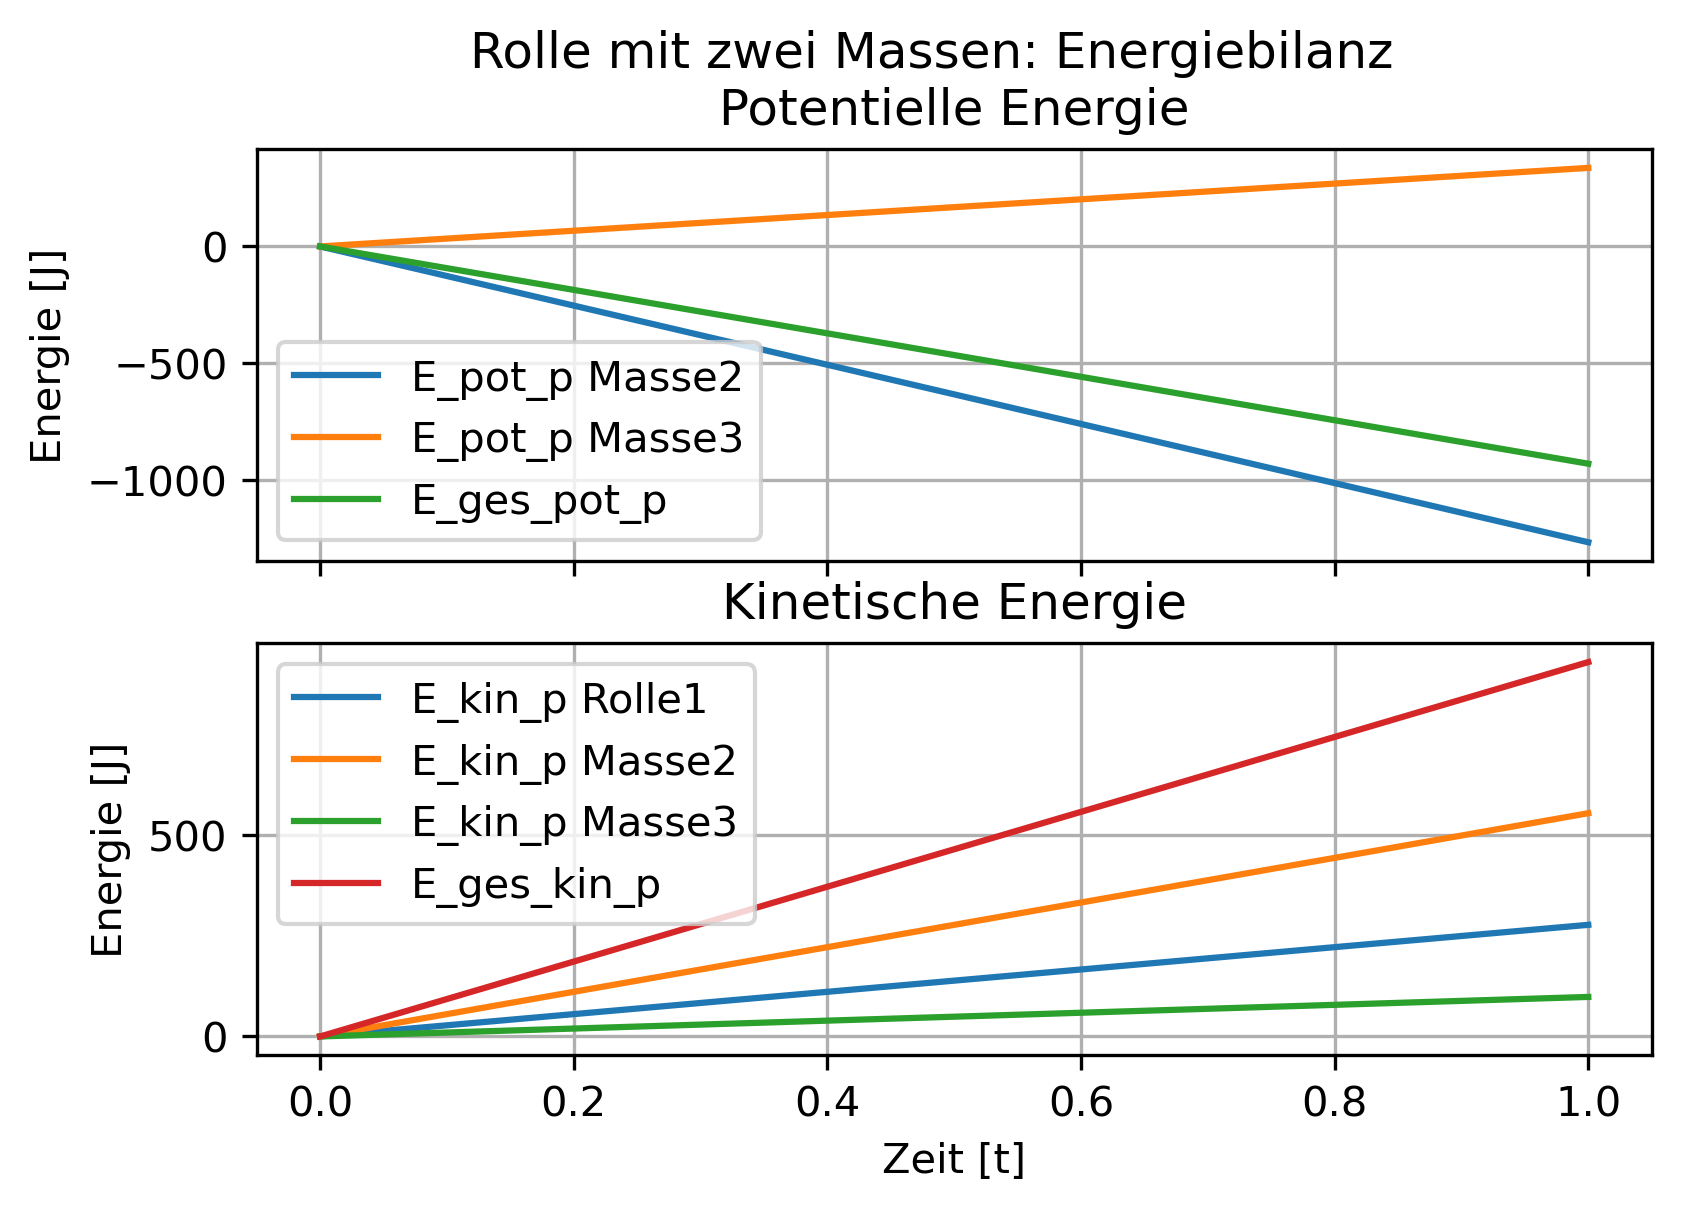

In [5]:
fig, axs = plt.subplots(2)
fig.patch.set_facecolor('white')
fig.suptitle('Rolle mit zwei Massen: Energiebilanz')
E_ges1 = []
E_ges2 = []
E_ges = []
for point in range(len(datenlogger_E2.E_pot)):
    E_ges1.append(datenlogger_E1.E_pot_p[point] + datenlogger_E2.E_pot_p[point] + datenlogger_E3.E_pot_p[point])     
    E_ges2.append(datenlogger_E1.E_kin_p[point] + datenlogger_E2.E_kin_p[point] + datenlogger_E3.E_kin_p[point])         
axs[0].plot(datenlogger_t,datenlogger_E2.E_pot_p,label='E_pot_p Masse2')
axs[0].plot(datenlogger_t,datenlogger_E3.E_pot_p,label='E_pot_p Masse3')
axs[0].plot(datenlogger_t,E_ges1,label='E_ges_pot_p')
axs[1].plot(datenlogger_t,datenlogger_E1.E_kin_p,label='E_kin_p Rolle1')
axs[1].plot(datenlogger_t,datenlogger_E2.E_kin_p,label='E_kin_p Masse2')
axs[1].plot(datenlogger_t,datenlogger_E3.E_kin_p,label='E_kin_p Masse3')
axs[1].plot(datenlogger_t,E_ges2,label='E_ges_kin_p')

for ax in axs.flat:
    ax.set(xlabel='Zeit [t]', ylabel='Energie [J]')
for ax in fig.get_axes():
    ax.label_outer()
axs[0].set_title('Potentielle Energie')
axs[1].set_title('Kinetische Energie')
axs[0].grid()
axs[1].grid()
axs[0].legend()
axs[1].legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_rolle_mit_zwei_gewichten4.png')

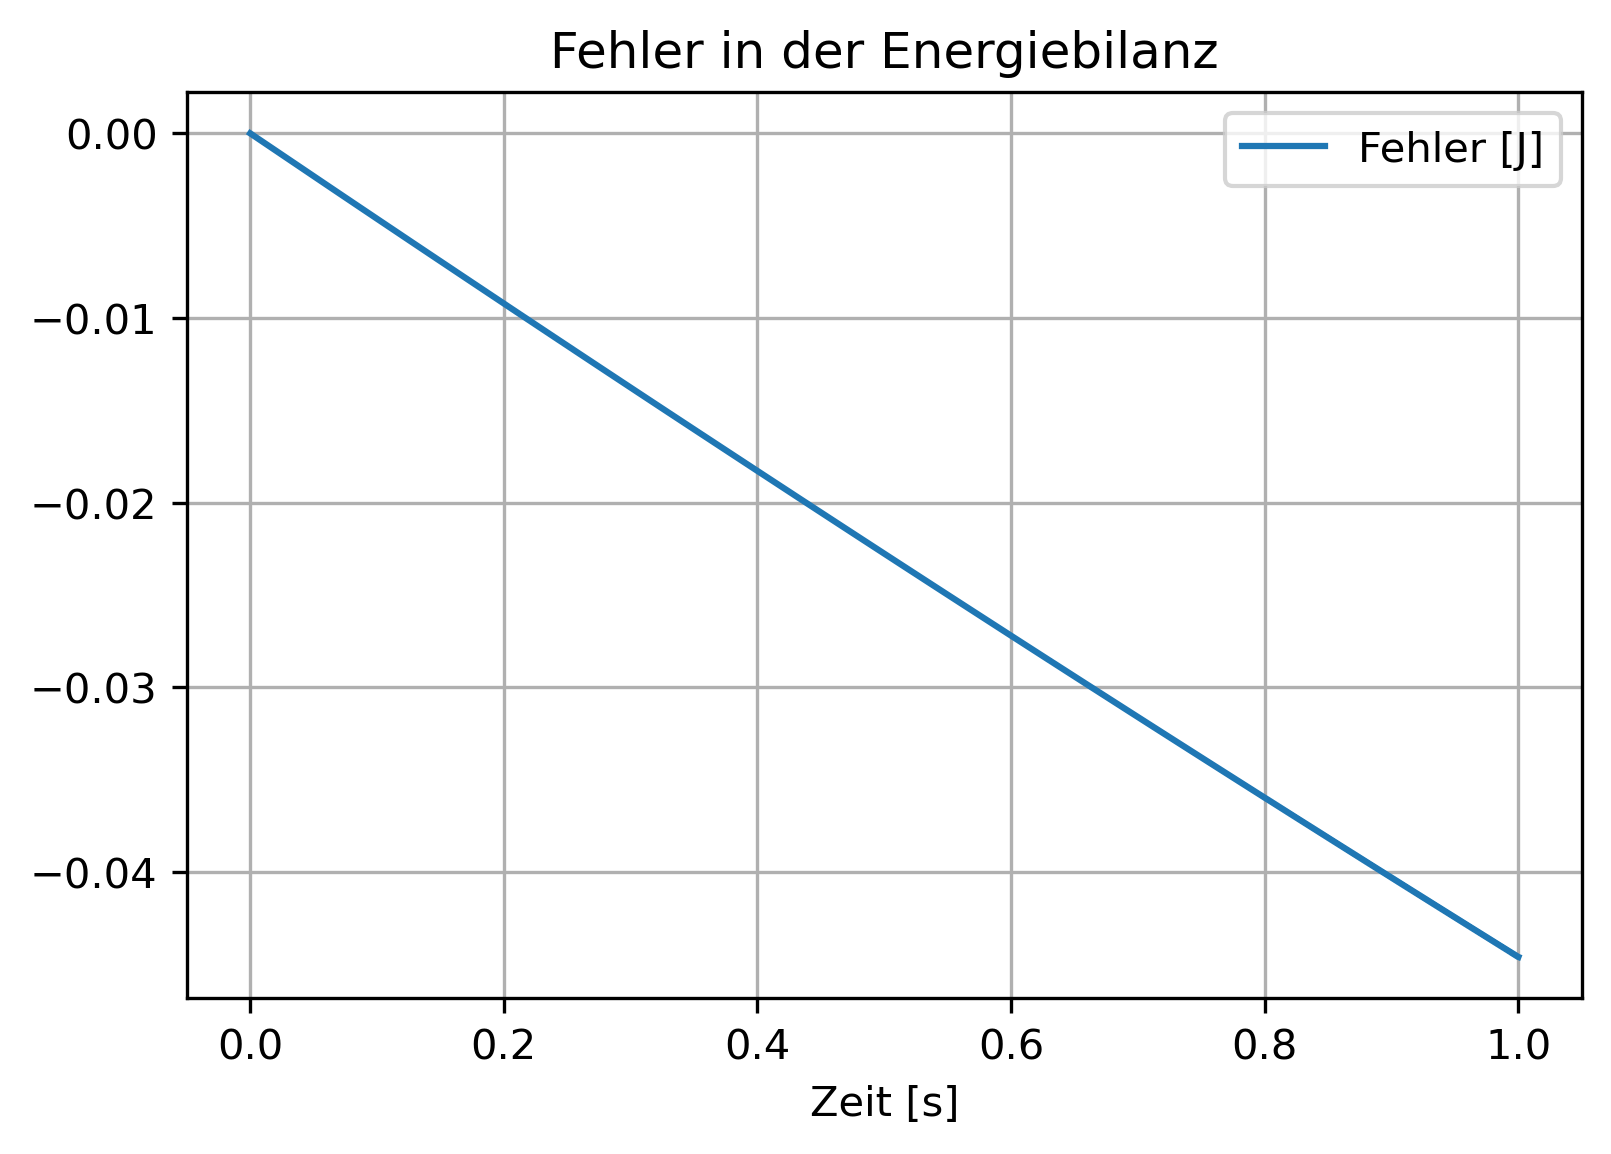

In [6]:
E_ges = []
for point in range(len(datenlogger_E2.E_pot)):
    E_ges.append(datenlogger_E2.E_pot[point] + datenlogger_E3.E_pot[point] + datenlogger_E1.E_kin[point] + datenlogger_E2.E_kin[point] + datenlogger_E3.E_kin[point])    
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Fehler in der Energiebilanz')
plt.plot(datenlogger_t,E_ges,label='Fehler [J]')
#plt.ylim(-3,3)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
#Analytische Lösung:
phi_pp = abs(Input_gz) * (Input_E2_Masse_m * Input_Kinematik_Ra - Input_E3_Masse_m * Input_Kinematik_Ri) / (1.5 * Input_E2_Masse_m * pow(Input_Kinematik_Ra,2) + Input_E3_Masse_m * pow(Input_Kinematik_Ri,2))
print("Phi_pp: "+str(phi_pp))

Phi_pp: 2.8641386925795054
